# Init Working Directory

In [78]:
import os

cwd = os.getcwd()

if cwd.endswith('prototype'):
    PATH = os.path.join('..', 'data', 'handwritten-hanacaraka')
    os.chdir(PATH)
    new_cwd = os.getcwd()

    print(f"The current working directory was: {cwd}")
    print(f"It has been changed to: {new_cwd}")

else:
    print(f"The current working directory is: {cwd}")

The current working directory is: C:\Users\Helmy\hanacaraka-classifier\data\clean-hanacaraka


# Removing Corrupted Datas

In [79]:
from PIL import Image

subdirs = [d for d in os.listdir() if os.path.isdir(d)]

image_files = []
for subdir in subdirs:
    image_files.extend([os.path.join(subdir, f) for f in os.listdir(subdir) if f.endswith('.png')])

print(f'Number of image files: {len(image_files)}\n')

Number of image files: 1562



In [80]:
corrupted_files = []
for image_file in image_files:
    try:
        img = Image.open(image_file)
    except:
        corrupted_files.append(image_file)

print(f'Number of corrupted files: {len(corrupted_files)}\n')

Number of corrupted files: 0



In [81]:
image_files = [f for f in image_files if f not in corrupted_files]

print(f'Number of image files after removing corrupted files: {len(image_files)}\n')

Number of image files after removing corrupted files: 1562



# Create New Directory for Selected Datas (Non-corrupted)

In [82]:
import shutil
import os


if (os.getcwd().endswith('handwritten-hanacaraka') 
        or not 
        os.path.exists(os.path.join('..', 'clean-hanacaraka'))):
    new_dir = os.path.join('..', 'clean-hanacaraka')

    for image_file in image_files:
        if os.name == 'nt':
            subdir, filename = image_file.split('\\')
        else:
            subdir, filename = image_file.split('/')
        subdir_path = os.path.join(new_dir, subdir)
        os.makedirs(subdir_path, exist_ok=True)
        new_filename = f'{subdir}_{len(os.listdir(subdir_path)) + 1}.png'
        shutil.copy(image_file, os.path.join(subdir_path, new_filename))

change the working directory to the new directory

In [83]:
os.chdir(new_dir)
new_cwd = os.getcwd()

print(f"The current working directory were: {new_cwd}")

The current working directory were: C:\Users\Helmy\hanacaraka-classifier\data\clean-hanacaraka


# Image Preprocessing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

the image were not clean, so we need to preprocess the image. Example of unclean image:

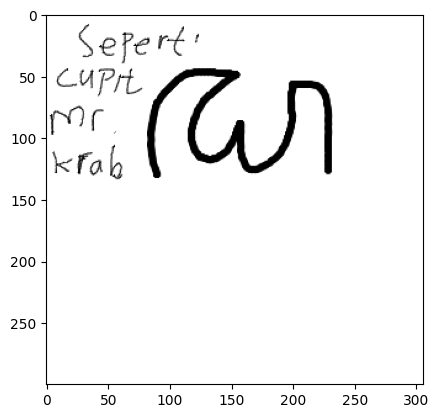

In [93]:
sample_img = ("dha\dha_21.png")
sample_img = cv2.imread(sample_img, cv2.IMREAD_GRAYSCALE)
plt.imshow(sample_img, cmap='gray')
plt.show()

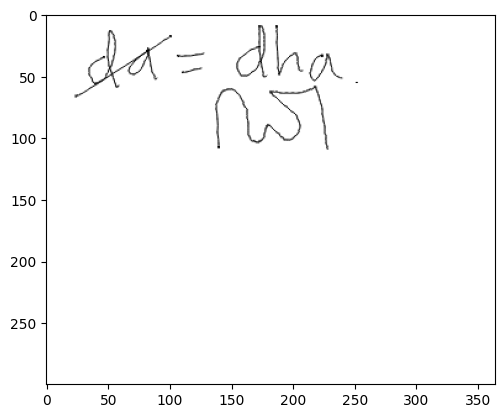

In [94]:
sample_img = ("dha\dha_37.png")
sample_img = cv2.imread(sample_img, cv2.IMREAD_GRAYSCALE)
plt.imshow(sample_img, cmap='gray')
plt.show()

function for preprocess the image

In [85]:
def cvt_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [86]:
def erode_img(img, kernel_size=(3,3)):
    kernel = np.ones(kernel_size, np.uint8)
    return cv2.erode(img, kernel, iterations=1)

In [87]:
def is_single_character(img):
    # Apply binary threshold
    _, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    # Return whether there is only one contour
    return len(contours) == 1

pipeline for preprocess the image

In [88]:
def preprocess_img(path):
    img = cv2.imread(path)
    img = cvt_grayscale(img)
    img = erode_img(img)
    if not is_single_character(img):
        return np.zeros_like(img)
    return img

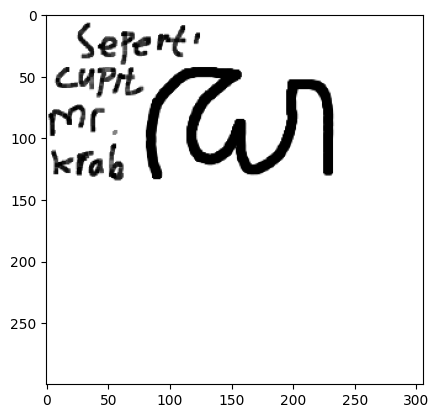

In [89]:
sample_img = ("dha\dha_21.png")
sample_img = preprocess_img(sample_img)

plt.imshow(sample_img, cmap='gray')
plt.show()

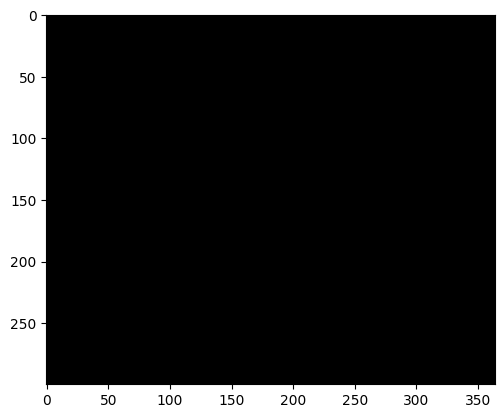

In [90]:
sample_img = ("dha\dha_37.png")
sample_img = preprocess_img(sample_img)

plt.imshow(sample_img, cmap='gray')
plt.show()